In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random
import pandas as pd
import glob
import fnmatch
from linfit import linfit
import matplotlib.pyplot as plt
import specmatchemp.library
import specmatchemp.plots as smplot
from scipy.integrate import trapz
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import CustomJS, Button
from bokeh.layouts import row, column
from fakescorr import fakescorr
#from lightkurve import KeplerTargetPixelFile

import os 

excl = {'M44': 219.,'Pleiades':196.}


def foldering(path):
    if os.path.exists(path)==False:
        os.mkdir(path)
    return

#-------------------------------
#FFD
#-------------------------------
def print_susp(specs, Tmin, Tmax,cluster, test,):
    select_suspicious = specs[(specs['T']>=Tmin) & (specs['T']<=Tmax)]
    for oid in select_suspicious.index.values:
        try:
            flux, flares = import_flares(cluster, test, oid)
        except FileNotFoundError:
            continue
        plt.figure(figsize=(10,2))
        plt.plot(flux.time,(flux.flux_gap-flux.flux_model))
        for i, row in flares.iterrows():
            plt.plot(flux.time.iloc[row.istart:row.istop],
                     (flux.flux_gap-flux.flux_model).iloc[row.istart:row.istop],
                     linewidth=2,
                     color='red',)
            plt.title(oid)
    return

def ED(start,stop,time,flux_model,flux_gap, error):
    
    '''
    Returns the equivalend duratio of a flare event,
    found within indices [start, stop],
    calculated as the area under the residual (flux_gap-flux_model)
    Returns also the error on ED following (Davenport 2016)
    
    Parameters:
    --------------
    start - start time index of a flare event
    stop - end time index of a flare event
    time - time array
    flux_model - model quiescent flux 
    flux_gap - long-term trend removed raw light curve
    error - rolling std error to raw flux
    
    Returns:
    --------------
    ed - equivalent duration in seconds
    ederr - uncertainty in seconds
    '''
    
    start, stop = int(start),int(stop)
    time = np.asarray(time)[start-1:stop+1]
    #model = pd.Series(np.asarray(flux_gap)[start:stop+1]).mean()
    model = np.asarray(flux_model)[start:stop+1]
    flux = np.asarray(flux_gap)[start:stop+1]
    error = np.asarray(error)[start:stop+1]
    residual = (flux - model)
    x = time*60.*60.*24.
    fx = residual/model
    ed = sum([(x[i]-x[i-1])*fx[i-1] for i in range(1,len(x))])
    #ed = trapz(residual/model,time*60.*60.*24.)
    #measure error on ED
    
    flare_chisq = chisq(flux, error, model)
    ederr = np.sqrt(ed**2 / (stop-start) / flare_chisq)
    return ed, ederr, flare_chisq

def chisq(data, error, model):
    '''
    Compute the normalized chi square statistic:
    chisq =  1 / N * SUM(i) ( (data(i) - model(i))/error(i) )^2
    '''
    return np.sum( ((data - model) / error)**2.0 ) / np.size(data)


def import_flares(cluster, test, oid):
    
    oid = int(float(oid))
    
    loc = 'stars_shortlist/{}/results/{}/results'.format(cluster,test)
    flux = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    flares = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])

    return flux, flares

def write_flares(forf,cluster, test, EPIC, typ='flares',extra=''):
    
    '''
    Writes a data frame with flares or flux 
    for a certain light curve with EPIC ID from a cluster
    analysed during a certain test.
    
    Parameter:
    ------------
    
    Returns:
    ------------
    '''
    
    loc = 'stars_shortlist/{}/results/{}'.format(cluster,test)
    if typ == 'flares':
        forf.to_csv('{}/{}_flares{}.csv'.format(loc,EPIC,extra))
    elif typ == 'flux':
        forf.to_csv('{}/{}_flux.csv'.format(loc,EPIC))
    return 



# def cum_hist(flares, flux, L_quiet,bins=5):
    
#     ED_=[]
#     s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']]
#     s_s = s_s.dropna()
#     for i,row in s_s.iterrows():
#         ed, ederr = ED(row['istart_no_sys_no_thruster'],
#                        row['istop_no_sys_no_thruster'],
#                        flux.time,flux.flux_model,flux.flux_gap)
        
#         if (ed != 'nan') & (ed >0):
#             ED_.append(np.log10(ed*24.*60.*60.*L_quiet))
    
#     hist, edges=np.histogram(ED_, bins=bins)
#     hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)

#     return hist, edges


DM = lambda x: 5.*np.log10(float(x))-5. 

def color_outlier_red(val,outliers):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if outliers.empty: outliers=[]
    color=[]
    for id_ in val:
        if id_ in list(outliers):
            color.append('red')
        else:
            color.append('black')
    return color



def energy(oid_list, cluster, test, C, LCtype, specs, Tmin, Tmax, fakes=False,onlyenergy=False):
    corr, edtrue = [], []
    durfactor = []
    listnames = ['clusterenergy','clusterenergy_err',
                 'L','Lerr',
                 'clustered','clusterederr',
                 'Teff','EPIC',
                 'istart','istop']
    tlistnames = ['tenergy','tenergy_err',
                      'tmyed',
                      'tL','tLErr']
    for name in listnames:
        vars()[name] = []
            
    for i, oid in enumerate(oid_list):
        print(oid)
        for name in tlistnames:
            vars()[name] = []
        
        try:
            flux, flares = import_flares(cluster, test, oid)
        except FileNotFoundError:
            
            continue
            
        specline = specs.loc[str(oid)]
        L_bol = specline['L_quiet_bol']
        L_bol_err = specline['L_quiet_bol_err']
        L_quiet = specline['L_quiet']
        L_quiet_err = specline['L_quiet_err']
        teff =  specline['T']
        if flares.empty:
            
            continue
        else:
            s_s = flares.dropna(how='any',subset=['istart_no_sys_no_thruster','istop_no_sys_no_thruster'])
            s_s['corrected'] = 1    
            
            
            for i,row in s_s.iterrows():
                ed, ederr, chi2 = ED(row['istart_no_sys_no_thruster'],
                               row['istop_no_sys_no_thruster'],
                               flux.time,flux.flux_model,flux.flux_gap, flux.error)
                energy_err = energyerr(ed, ederr, L_quiet, L_quiet_err)
          
                if (ed != 'nan') & (ed > 0):
                    results = [ed*L_quiet, energy_err,
                              L_bol,L_bol_err,
                              ed,ederr,
                              teff,oid,
                              row.istart,row.istop]
                    for (name,result) in zip(listnames,results):
                        vars()[name].append(result)
                    for (name,result) in zip(tlistnames,results[:5]):
                        vars()[name].append(result)

                    
                else:

                    for name in listnames+tlistnames:
                        vars()[name].append(np.nan)
        keys = ['myenerg','myenerg_err','L_bol','L_bol_err','myed',]
        for (key,name) in zip(keys,tlistnames):
            s_s[key] = vars()[name]

        if (fakes==True) & (onlyenergy==False): 
      #      try:
            s_s = fakescorr(s_s, oid, C, cluster, test, LCtype)
            s_s['energ_true'] = s_s.ED_true*L_quiet
           # except (FileNotFoundError, IndexError):
           #     s_s['corrected'] = np.nan
        if (fakes==True) & (onlyenergy==True): 
      #      try:
            s_s = fakescorr(s_s, oid, C, cluster, test, LCtype)
            s_s['energ_true'] = s_s.ED_true*L_quiet
            s_s['count_true'] = 1
           # except (FileNotFoundError, IndexError):
           #     s_s['corrected'] = np.nan
        elif (fakes==False) & (onlyenergy==False): 
            s_s['count_true'] = 1
            s_s['energ_true'] = tenergy
        corr.append(list(s_s.count_true))
        edtrue.append(list(s_s.energ_true))
        
        #helper to get rid of extra columns from I/O
        filtered = fnmatch.filter(s_s.columns.values, 'Unnamed:*')
        s_s = s_s.drop(filtered,axis=1)
        
        write_flares(s_s, cluster, test, oid, typ='flares') 
    
    #unpack list of lists
    corr = [i for item in corr for i in item]
    edtrue = [i for item in edtrue for i in item]
    
    d = dict()
    dfnames = ['clusterenergy','clusterenergy_err',
               'L_bol','L_bol_err',
               'clustered','clusterederr',
               'Teff','EPIC',
               'istart','istop']
    for (dfname,name) in zip(dfnames,listnames):
        d[dfname] = vars()[name]
    d['stars_in_bin'] = len(oid_list)
    d['Tmin'] = Tmin
    d['Tmax'] = Tmax
    d['count_true'] = corr
    d['energ_true'] = edtrue

    return pd.DataFrame(d)

def energyerr(ed, ederr, L_quiet, L_quiet_err):
    #np.sqrt((ed * L_quiet_err)**2 + (ederr * L_quiet)**2) #in case I want to do it quadratically
    return (ed * L_quiet_err) + (ederr * L_quiet)

# def FFD(oid, cluster, test, specs,color='red'):
#     flux, flares = import_flares(cluster, test, oid)
#     T = specs['T'].loc[oid]
#     L_quiet = specs['L_quiet'].loc[oid]
#     histAppa, edgesAppa = cum_hist(flares, flux, L_quiet,bins=5)
#     binmids=[(x+edgesAppa[i])/2. for i,x in enumerate(edgesAppa[1:])]
#     return plt.plot(binmids[1:],np.log10(histAppa[1:]),color=color,alpha=0.8,label='EPIC {}, T={}K'.format(oid,T))




## Load parameters and calculate quiescent luminosity, assign spectral class and  if not already

In [3]:
cluster_dict = {'M67':['M67','M67', 15, 4.0, 850],
                #'Ruprecht_147':['Ruprecht 147','Ruprecht_147', 30, 2.5, 300.],
                'M44':['M44','M44', 47, 0.73, 181.5],
                #'M45':['M45','M45',55.,0.12,120.],
                'NGC_1647':['NGC 1647','NGC_1647',0.,0.145,550.],
                'Pleiades':['Pleiades','Pleiades',0.,0.120,136.]
               }

cluster ='M44'
basics = cluster_dict[cluster]
test = 'run_06'
C = '05'
LCtype = 'k2sc'
dm = DM(basics[4])
global dm
#l = 'stars_shortlist/{0}/{0}_parameter.csv'.format(cluster)
l = 'stars_shortlist/{0}/results/{1}/catalog/{0}_parameter.csv'.format(cluster,test)
print(glob.glob(l))
if glob.glob(l) != []:
    specs = pd.read_csv(l)
    specs.EPIC = specs.EPIC.astype(float).astype(int)
    specs = specs.set_index('EPIC')
else:
    print('Go back to step 6.')
specs = specs.rename(index = str, columns={'n_appa_flares':'counts',
                                           ' Total Exposure Time of LC in Days ':'dur'})

specs['dur'] = (specs.dur-excl[cluster]*29.4/60./24.)/365.25 # true duration in years
specs[['dur','counts','T','T_err','L_quiet','L_quiet_err','L_quiet_bol_err']]


['stars_shortlist/M44/results/run_06/catalog/M44_parameter.csv']


,dur,counts,T,T_err,L_quiet,L_quiet_err,L_quiet_bol_err
EPIC,,,,,,,
211700306,0.165313,0,3500,70.945989,8.757554e+29,2.850798e+29,8.089374e+28
211708110,0.165313,2,3030,51.316014,8.532626e+28,2.713417e+28,1.160077e+27
211725787,0.165416,0,3030,51.316014,8.532626e+28,2.713417e+28,1.160077e+27
211727975,0.165364,0,3200,76.376262,1.996229e+29,7.167790e+28,1.123513e+28
211729756,0.164231,1,3410,126.622799,6.307035e+29,2.743450e+29,4.763377e+28
211734093,0.165210,0,3650,76.376262,1.566558e+30,5.096503e+29,3.385205e+29
211738707,0.165158,1,3100,85.440037,1.489625e+29,5.788315e+28,2.274462e+27
211745306,0.165261,1,3200,76.376262,1.996229e+29,7.167790e+28,1.123513e+28
211748286,0.165313,3,3200,76.376262,1.996229e+29,7.167790e+28,1.123513e+28


## Begin: Deprecated from run_05:

In [85]:
#lowtemp = specs.index.values[specs['T']<4500]
fails = pd.read_csv('stars_shortlist/{}/results/{}/results/Lombscargle_fails.txt'.format(cluster, test),
                   header=None,index_col=0)
overlap = list(set(fails.index.values) & set(specs.index.values))
print(overlap)
params = specs.loc[overlap]
#flux, flares = import_flares(cluster, test, overlap[0])
# plt.figure(figsize=(10,2))
# plt.plot(flux.time,flux.flux_gap)
# for i, row in flares.iterrows():
#     plt.plot(flux.time.iloc[np.arange(row.istart,row.istop)],
#              flux.flux_gap.iloc[np.arange(row.istart,row.istop)],
#              linewidth=5,
#              color='red')
#flares.columns.values

[211076042, 211060530, 211073598]


In [3]:
flarelist = pd.read_csv('stars_shortlist/{0}/results/{1}/results/{0}_{1}_flarelist.txt'.format(cluster,test),
    delimiter='\t')
#flarelist = flarelist[['Object ID ',' Number of Flares ']]
flarelist = flarelist.rename(index=str, columns= {'Object ID ':'EPIC',
                                                  ' Number of Flares ':'counts',
                                                  ' Total Exposure Time of LC in Days ':'dur'})
flarelist.dur = flarelist.dur*24.
flarelist = flarelist.drop_duplicates(subset='EPIC')
flarelist = flarelist.set_index('EPIC')
#specs=specs.drop('counts', axis=1)
specs = specs.join(flarelist, how='left')
specs.counts.head()


ValueError: columns overlap but no suffix specified: Index([' Date of Run ', ' Filename ', ' BJD-2454833 days '], dtype='object')

In [7]:
flarelist = flarelist[~flarelist[' Filename '].str.contains('everest')]

,Date of Run,counts,Filename,dur,BJD-2454833 days
EPIC,,,,,
211389428,2018-08-20 08:32:06.274449,0,stars_shortlist/M67/hlsp_k2sc_k2_llc_211389428...,1555.540000,2306.631466
211389537,2018-08-20 08:32:15.507747,1,stars_shortlist/M67/hlsp_k2sc_k2_llc_211389537...,1553.733333,2306.631465
211389716,2018-08-20 08:32:24.666235,0,stars_shortlist/M67/hlsp_k2sc_k2_llc_211389716...,1535.666667,2306.631448
211389931,2018-08-20 08:32:33.687325,0,stars_shortlist/M67/hlsp_k2sc_k2_llc_211389931...,1557.798333,2306.631452
211390071,2018-08-20 08:34:49.742132,0,stars_shortlist/M67/hlsp_k2sc_k2_llc_211390071...,1556.895000,2306.631492
211390107,2018-08-20 08:34:49.869118,0,stars_shortlist/M67/hlsp_k2sc_k2_llc_211390107...,1553.281667,2306.631492
211390158,2018-08-20 08:34:49.996902,0,stars_shortlist/M67/hlsp_k2sc_k2_llc_211390158...,1549.668333,2306.631444
211390800,2018-08-20 08:34:50.122500,0,stars_shortlist/M67/hlsp_k2sc_k2_llc_211390800...,1554.636667,2306.631503
211391125,2018-08-20 08:34:50.253433,0,stars_shortlist/M67/hlsp_k2sc_k2_llc_211391125...,1556.443333,2306.631458


## End: Deprecated from run_05

In [4]:
# def check_tpfs(c,cluster):
#     c['contaminatedTPF'] = np.nan
#     for i, row in c.iterrows():
#         tpf = KeplerTargetPixelFile('stars_shortlist/{}'.format(cluster))
#         cadences = np.arange(row.istart-3, row.istop+3)
#         row.contaminatedTPF = checkresiduals(tpf,cadences).shape[0]
#     print(c.head())
#     return c

def cum_hist_average(oid_list, cluster, test, C, LCtype, specs, Tmin, Tmax,fakes=False,onlyenergy=False):
    
    thr = pd.read_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_05_median_detection_thresholds_melted.csv'.format(test[-2:]))
    emin = thr.threshold[(thr.cluster == cluster) & (thr.Tmax == Tmax) & (thr.Tmin == Tmin)].tolist()[0]
    try:
        #normalize = 1./len(oid_list)
        
        c = energy(oid_list, cluster, test, C, LCtype, specs, Tmin, Tmax, fakes=fakes,onlyenergy=onlyenergy)
        c = c.dropna(how='any')#,subset='clusterenergy')
        print('uncorrected ',c.shape)
#         print(specs.index.values,oid_list)
#         print(specs[specs.index.isin(oid_list)])
        normalize = 1./(specs[specs.index.astype(int).isin(oid_list)].dur.sum())
        #the durfactor accounts for removed thruster firings and systematics
        print('True observation time: {:.1f} years.'.format(1./normalize))
        if ((fakes == True) & (onlyenergy==False)) :
            c = c.sort_values(by=['energ_true'])
            #print(emin)
            c = c[c.count_true < 5.]
            c = c[c.energ_true > emin]
           # print(c.head())
            #c = check_tpfs(c, cluster)
            hist_err = np.asarray(c.count_true**2)
            hist = np.ones_like(c.energ_true)
            print('corrected ',c.shape)
            
        elif ((fakes == True) & (onlyenergy==True)) :
            c = c.sort_values(by=['energ_true'])
            #c = c[c.count_true < 2.]
            #c = check_tpfs(c, cluster)
            hist = np.ones_like(c.energ_true)
            hist_err = np.ones_like(c.energ_true)**2
            hist_err[-1] = 1.01
        elif ((fakes == False) & (onlyenergy==False)) :
            c = c.sort_values(by=['clusterenergy'])
            #c = check_tpfs(c,cluster)
            hist = np.ones_like(c.clusterenergy)
            hist_err = np.ones_like(c.clusterenergy)**2
            hist_err[-1] = 1.01
        
        hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)
        hist_err = np.sqrt(np.flip(np.cumsum(np.flip(hist_err,axis=0)),axis=0))
      
        err = np.asarray(c.clusterenergy_err**2)
        err = np.sqrt(np.flip(np.cumsum(np.flip(err,axis=0)),axis=0))/hist
        if fakes==True:
            df = pd.DataFrame({'hi':hist,
                               'energ': c.energ_true,
                               'err':err,
                               'hi_err':hist_err,
                               'norm':normalize})
        elif fakes==False:
            df = pd.DataFrame({'hi':hist,
                               'energ':c.clusterenergy,
                               'err':err,
                               'hi_err':hist_err,
                               'norm':normalize})


        return df,c
    except ZeroDivisionError:
        return pd.DataFrame

def FFD_average(specs, cluster, test, LCtype, class_='K7', 
                Tmin=3000., Tmax=7000., color='red',axis=plt,
                subset='class',Minenerg=5e31,Maxenerg=5e37,fakes=False,
                marker='o',onlyenergy=False):
    loc = 'stars_shortlist/share/clusterenergies_{0}_{1}_{2}_{3}.csv'.format(cluster,test,Tmin,Tmax)
    if subset == 'class':
        select = np.asarray([i for sublist in [specs[specs.spec_class.str.contains(c)].index.values 
                                               for c in class_] 
                                                 for i in sublist])
        label = '{}, n={}'.format(tuple(class_),len(select))
    elif subset == 'temperature':
        select = np.asarray([int(float(i)) for i in specs[(specs['T']>=Tmin) & (specs['T']<=Tmax)].index.values])
        label = r'${}$K-${}$K, $n_*={:3d}$'.format(int(Tmin),int(Tmax),len(select))
        samplesize=len(select)
    
    try:
        df,c = cum_hist_average(select, cluster, test, C,LCtype, specs, Tmin, Tmax,fakes=fakes,onlyenergy=onlyenergy)
        print('{} observation duration in {}-{}K bin is {}.'.format(cluster,Tmin,Tmax,df.norm.iloc[0]))
    except TypeError:
        print('probably empty list')
        return [np.nan,np.nan],[np.nan,np.nan], np.nan, samplesize, 0
    
    if df.empty:
        print('Empty sequence.')
        return [np.nan,np.nan],[np.nan,np.nan], np.nan, samplesize, 0
    else:
        df = df[(df.energ > Minenerg) &  (df.energ < Maxenerg)]
        c = c[(c.energ_true > Minenerg) &  (c.energ_true < Maxenerg)]
        df = df.dropna(how='any')
        c = c.dropna(how='any')
        

    
    hist, binmids, err, hi_err = np.asarray(df.hi), np.asarray(df.energ), np.asarray(df.err), np.asarray(df.hi_err)
    
    try:
       
        df2 = df.copy()
        df2.norm = np.log10(df.norm)
        df2['energ'] = np.log10(df.energ)
        df2['hi'] = np.log10(df.hi)
        df2['hi_err'] = np.log10(df.hi+df.hi_err)-df2.hi
        df2['err'] = np.log10(df.energ+df.err)-df2.energ
        df2['hi_err_low'] = df2.hi - np.log10((df.hi-df.hi_err).map(lambda x: max(0.005,x)))
        print(df2.shape)
        df2 = df2.dropna(how='any')
        print(df2.shape)
        df2['rho'] = 0
        df2 = df2.rename(index=str, columns={'energ':'x','hi':'y',
                                             'hi_err':'sigy','err':'sigx'})
        m, b = linfit(df2,axis=axis)
        print(m,b)
    except (IndexError,ValueError):
        return [np.nan,np.nan],[np.nan,np.nan], np.nan, samplesize, 0

    if fakes==True: 
        corr = 'corrected'
        if onlyenergy==True: corr='only energy correction'
        
    else: 
        corr = 'uncorrected'
    alpha = r'{:.2f}\pm{:.2f}'.format(m[0]-1,m[1])
    a = r'$\alpha$'
    print(axis)
    axis.fill_between(df2.x, df2.y-df2.hi_err_low+ df2.norm, df2.y+df2.sigy+ df2.norm,
                     alpha=0.2,color='r')
    axis.scatter(df2.x, df2.y+ df2.norm, 
                 label=r'{}, $n_f={:3d}$, $\alpha={}$'.format(label,df2.shape[0],alpha),
                color='k',marker=marker)
    
    results = pd.DataFrame({'logE':df2.x,'count_per_yr':df2.y+df2.norm,
                            'low_yerr':df2.hi_err_low,'high_yerr':df2.sigy,
                            'alpha':m[0]-1.,'beta':b[0],'alpha_err':m[1],'beta_err':b[1],
                            'cluster':cluster,'Tmin':Tmin,'Tmax':Tmax,'n_obj':len(select),
                            'maxenerg':df.energ.max(),'nflares':df2.y.shape[0],
                            })
    results.to_csv('stars_shortlist/share/{}_{}_{}_{}_FFD.csv'.format(test,cluster,Tmin,Tmax))
    c.to_csv('stars_shortlist/share/{}_{}_{}_{}_energs.csv'.format(test,cluster,Tmin,Tmax))
    return [m[0],b[0]], [m[1],b[1]], df.energ.max(), samplesize, len(df)


In [5]:
trange = {'M44': [
                   (3e3,7e3,'k', 5e28, 5e36),   
                   (3e3,3.249e3,'red', 5e28, 5e36),
                   (3.25e3,3.499e3,'orange', 5e28, 5e36),
                   (3.5e3,3.749e3,'green', 5e28, 5e36),
                   (3.75e3,4e3,'c', 5e28, 5e36),
                 ],
          'M67': [  (3e3,7e3,'k', 5e28, 5e36),      
                   (3e3,3.249e3,'red', 5e28, 5e36),
                   (3.25e3,3.499e3,'orange', 5e28, 5e36),
                   (3.5e3,3.749e3,'green', 5e28, 5e36),
                   (3.75e3,4e3,'c', 5e28, 5e36),],
     'Pleiades': [
                  (3e3,7e3,'k', 5e28, 5e36),
                  (3e3,3.249e3,'red', 5e28, 5e36),
                  (3.25e3,3.499e3,'orange', 5e28, 5e36),
                  (3.5e3,3.749e3,'green', 5e28, 5e36),
                  (3.75e3,4e3,'c', 5e28, 5e36),
                  ],}

fakes = True
corr = 'corrected'
trange[cluster]

[(3000.0, 7000.0, 'k', 5e+28, 5e+36),
 (3000.0, 3249.0, 'red', 5e+28, 5e+36),
 (3250.0, 3499.0, 'orange', 5e+28, 5e+36),
 (3500.0, 3749.0, 'green', 5e+28, 5e+36),
 (3750.0, 4000.0, 'c', 5e+28, 5e+36)]

211700306
211708110
211725787
211727975
211729756
211734093
211738707
211745306
211748286
211771406
211773459
211776073
211778044
211781289
211781646
211787610
211789682
211790121
211795051
211795467
211795569
211795614
211795706
211796017
211799258
211799259
211799551
211800408
211801146
211803674
211810140
211810915
211812724
211817992
211820823
211822797
211826149
211827220
211827466
211827577
211829936
211832848
211833336
211834355
211835162
211838068
211839847
211841501
211841807
211841991
211842439
211845034
211845069
211846954
211847321
211847798
211851325
211884968
211885995
211886612
211887287
211887839
211888866
211889082
211889983
211890182
211890216
211890774
211891321
211891359
211891774
211891961
211892153
211892240
211892510
211892898
211893704
211894087
211895099
211895966
211896120
211896418
211896450
211896596
211896670
211896749
211896912
211896957
211896979
211897054
211897713
211897821
211897893
211898181
211898294
211898716
211899094
211899790
211899994
211900414


211901894
211902261
211902720
211902826
211903302
211905265
211905618
211905676
211906671
211906702
211907026
211907293
211907530
211907679
211908029
211908085
211909798
211911467
211911911
211912899
211913669
211913907
211914124
211914889
211915085
211915709
211915785
211915940
211916235
211916505
211916718
211917139
211918998
211919680
211920429
211920710
211921859
211923388
211924377
211925013
211925319
211925698
211926133
211926166
211926605
211927174
211928526
211928574
211929980
211931651
211931872
211934092
211934172
211935588
211936049
211936457
211936741
211937242
211937538
211937565
211938090
211938350
211938530
211938817
211938911
211938988
211939350
211939364
211939989
211940389
211940576
211943375
211943550
211943617
211944193
211945119
211945329
211945337
211945445
211945502
211945980
211946007
211946732
211946750
211948030
211948214
211948895
211949163
211949413
211950298
211950696
211950716
211950886
211951021
211951112
211951223
211951283
211951438
211951824
211952571


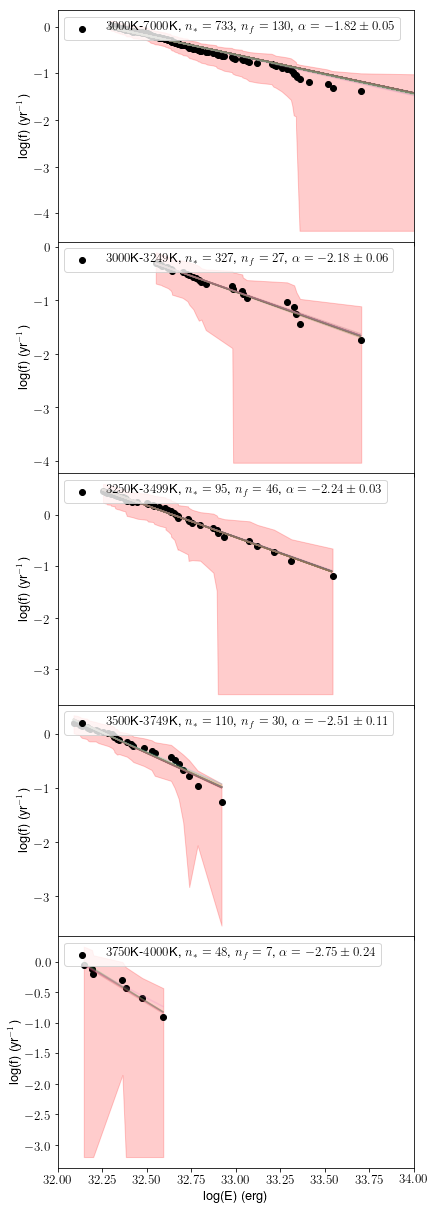

In [6]:
from matplotlib import rc, rcParams
rc('text', usetex=True)
rc('font', size=13)
rc('legend', fontsize=13)
rcParams.update({'font.size':13})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('mathtext', fontset='stixsans')

header = ['Tmin','Tmax','alpha','beta','alpha_err',
          'beta_err','minenerg','maxenerg','n_obj','nflares',
          'corrected']
results = pd.DataFrame(columns=header)
#specs2 = specs.drop(overlap) # deprecated from run_05
specs2 = specs[specs.todrop == False]
#specs2 = specs2.drop(['211729756','211745306','211748286'])
axs = tuple(['ax{}'.format(i) for i in range(5)])
fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(nrows=5,ncols=1,figsize=(6.1,17),sharex=True)#8 5 

idx = 0
for (Tmin, Tmax, color, minenerg, maxenerg) in trange[cluster]:#fitset2[cluster][corr][:4]

    
    p, var, maxenerg, n_obj, n_flares = FFD_average(specs2, cluster, test, LCtype, color='r',
                                                    marker = 'o',axis=vars()[axs[idx]],
                                                    Tmin=Tmin, Tmax=Tmax, subset='temperature',
                                                    Minenerg=minenerg, Maxenerg=maxenerg,
                                                    fakes=True,onlyenergy=False)
    
 

    vars()[axs[idx]].set_xlabel('log(E) (erg)')
    vars()[axs[idx]].set_ylabel('log(f) (yr$^{-1}$)')

    #vars()[axs[idx]].set_ylim(-5.5,-2.8)
    vars()[axs[idx]].set_xlim(32.,34)
    vars()[axs[idx]].legend(loc=2, fontsize='medium')
    idx+=1
    
plt.tick_params(axis = 'both', labelsize = 13)

plt.tight_layout()
plt.subplots_adjust(hspace=0)
#plt.savefig('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/Paper/M44FFD_grouped_threshs.png',dpi=300)

In [ ]:
sus = specs[specs.counts >5]
sus

In [ ]:

print_susp(sus, 3000, 3500, cluster, test,)

In [ ]:
def print_susp2(specs2, oid,cluster, test,):
    select_suspicious = specs2.loc[oid]

    try:
        flux, flares = import_flares(cluster, test, oid)
    except FileNotFoundError:
        pass
    plt.figure(figsize=(12,4))
    plt.plot(flux.time,(flux.flux_gap-flux.flux_model))
    
    
    for i, row in flares.iterrows():
        s,t =row.istart_no_sys_no_thruster,row.istop_no_sys_no_thruster
        plt.plot(flux.time.iloc[s:t+1],
                 (flux.flux_gap-flux.flux_model).iloc[s:t+1],
                 linewidth=2,
                 color='orange')
        plt.gca().fill_between(flux.time,
                              -flux.error,
                              flux.error,
                               color="#dddddd")
    
    f = flares[flares.count_true < 2.]
    print(flares.head())
    for i, row in f.iterrows():
        s,t =row.istart_no_sys_no_thruster,row.istop_no_sys_no_thruster
        plt.plot(flux.time.iloc[s:t+1],
                 (flux.flux_gap-flux.flux_model).iloc[s:t+1],
                 linewidth=2,
                 color='red')
        plt.gca().fill_between(flux.time,
                              -flux.error,
                              flux.error,
                               color="#dddddd")
        plt.title(oid)
    plt.xlim(2260,2290)
    plt.xlabel('Time (BJD - 2454833 days)')
    plt.ylabel('Flux (arb. u.)')
    plt.legend()
   # plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/k2sc_fail.png',
         #       dpi=300)


print_susp2(specs, 211046948,cluster, test)

In [ ]:
from matplotlib import rc, rcParams
rc('text', usetex=True)
rc('font', size=13)
rc('legend', fontsize=13)
rcParams.update({'font.size':13})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('mathtext', fontset='stixsans')

header = ['Tmin','Tmax','alpha','beta','alpha_err',
          'beta_err','minenerg','maxenerg','n_obj','nflares',
          'corrected']
results = pd.DataFrame(columns=header)
specs2 = specs.drop(overlap)
plt.figure(figsize=(6,4))#8 5 
for (Tmin, Tmax, color, minenerg, maxenerg) in trange[cluster][2:3]:#fitset2[cluster][corr][:4]:
    #plt.figure(figsize=(8,5))
    print(Tmin,Tmax)
    #plt.title('Cumulative FFD: {}'.format(cluster))
    
    
#     p, var, maxenerg, n_obj, n_flares = FFD_average(specs2, cluster, test, LCtype, color='green',
#                                                     marker = '+',
#                                                     Tmin=Tmin, Tmax=Tmax, subset='temperature',
#                                                     Minenerg=minenerg, Maxenerg=maxenerg,
#                                                     fakes=False,onlyenergy=False)
    
#     l = [[i] for i in [Tmin, Tmax, p[0], p[1], 
#                        var[0], var[1], minenerg, 
#                        maxenerg, n_obj, n_flares, False]]
#     t = pd.DataFrame(dict(list(zip(header,l))))
#     results = results.append(t,ignore_index=True)
    
    
#     p, var, maxenerg, n_obj, n_flares = FFD_average(specs2, cluster, test, LCtype, color='blue',
#                                                     marker = 'o',
#                                                     Tmin=Tmin, Tmax=Tmax, subset='temperature',
#                                                     Minenerg=minenerg, Maxenerg=maxenerg,
#                                                     fakes=fakes,onlyenergy=True)
    
#     l = [[i] for i in [Tmin, Tmax, p[0], p[1], 
#                        var[0], var[1], minenerg, 
#                        maxenerg, n_obj, n_flares, fakes]]
#     t = pd.DataFrame(dict(list(zip(header,l))))
#     results = results.append(t,ignore_index=True)
    
    
    p, var, maxenerg, n_obj, n_flares = FFD_average(specs2, cluster, test, LCtype, color='r',
                                                    marker = 'o',
                                                    Tmin=Tmin, Tmax=Tmax, subset='temperature',
                                                    Minenerg=minenerg, Maxenerg=maxenerg,
                                                    fakes=True,onlyenergy=False)

    l = [[i] for i in [Tmin, Tmax, p[0], p[1], 
                       var[0], var[1], minenerg, 
                       maxenerg, n_obj, n_flares, fakes]]
    t = pd.DataFrame(dict(list(zip(header,l))))
    results = results.append(t,ignore_index=True)
    
    
    plt.legend()
    plt.xlabel('log(E) (erg)')
    plt.ylabel('log(f) (yr$^{-1}$)')
    plt.tick_params(axis = 'both', labelsize = 13)
    plt.ylim(-5.,-3)
    plt.xlim(31.5,33.5)
    plt.tight_layout()


In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# build a rectangle in axes coords
left, width = 0.35, .5
bottom, height = 0.4, .5
right = left + width
top = bottom + height
# ax = plt.gca()
# p = plt.Rectangle((left, bottom), width, height,
#               fill=False,
#               )



# ax.text(left, bottom, 'left top',
#         horizontalalignment='left',
#         verticalalignment='top',
#         transform=ax.transAxes)


def Teff_count(specs,cluster):
    specs['logL'] = np.log10(specs.L_quiet)
    
    plot = specs.plot(x='T',y='logL',
                      kind = 'scatter', 
                      color='black',
                      s=list(specs['counts']**2),
                      marker='o',
                      alpha=0.2,
                      title = '{}'.format(cluster),)
                      #figsize=(7,7))
    plot.set_ylabel('log(L_quiet)')
    plot.set_xlabel('T_eff')
    #plot.text(6.5, 6.5cm, r'1 flare', fontsize=11)
    plt.plot(5900, 30.82, 'o', markersize=25,color='black')
    fig = plot.get_figure()
    #fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/Teff_{}_counts.jpg'.format(cluster),dpi=300)
    return

def CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5),outliers=pd.Series()):
    '''
    Plots and saves CMDs for specified bands, 
    marks outliers if any are passed.
    '''
    #drops = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/Pleiades/redgiants.csv',
         #              header=None, names=['EPIC'])
    #print(drops.shape,specs.shape)
    #specs = specs.drop(drops.EPIC.tolist())
    #print(drops.shape,specs.shape)
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,
                      kind = 'scatter', color='black',
                     # color=color_outlier_red(specs.index.values,drops.EPIC),
                      s=list(specs['counts']**2./2),
                      title = '{}'.format(cluster),
                      alpha=0.5,figsize=(6,5))
    
    
    plot.set_ylabel(cid1[0])
    plot.set_xlabel('{}-{}'.format(cid1[0],cid2[0]))
    plot.text(right, top, r'5 flares', transform=plot.transAxes, fontsize=11)
    plot.plot(right-.03, top+0.016, 'o', markersize=25/2,color='black', transform=plot.transAxes)

    fig = plot.get_figure()
    ax = plt.gca()
    plt.Rectangle((left, bottom), width, height,
              fill=False,
              )
    plt.set_transform(ax.transAxes)
    plt.set_clip_on(False)
    #ax.add_patch(p)

    #fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/CMD_{}_{}_counts.jpg'.format(cluster,color),dpi=300)
    return

# CMD_count(specs,cluster,cid1='gmag',cid2='zmag',color='g_z',ylim=(16,9))
#CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(16,9))
#CMD_count(specs,cluster,cid1='J',cid2='K',color='J_K',ylim=(13,4))
# CMD_count(specs,cluster,cid1='rmag',cid2='zmag',color='r_z',ylim=(14.5,8))#,text=(16.5))
Teff_count(specs,cluster)

specs2 = specs.drop(overlap)
print(specs2[(specs2['T']>=3000.) & (specs2['T']<=7000.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3000.) & (specs2['T']<=3249.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3250.) & (specs2['T']<=3499.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3500.) & (specs2['T']<=3749.)].dur.sum()/24/365)
print(specs2[(specs2['T']>=3750.) & (specs2['T']<=4000.)].dur.sum()/24/365)